In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy.stats import zscore
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder


from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Data Segmentation and Feature Ranking
1. Group attributes based on VIF scores into 5 groups
2. Apply Z-score normalization
3. Apply PCA on each of the 5 groups
4. Keep PC's from each group that achieve at least 90% of expalined variance
5. Also append 3 columns from orginal dataset with the least VIF values

In [2]:
def variance_inflation_factor(exog, exog_idx):
    k_vars = exog.shape[1]
    x_i = exog[:, exog_idx]
    mask = np.arange(k_vars) != exog_idx
    x_noti = exog[:, mask]
    r_squared_i = sm.OLS(x_i, x_noti).fit().rsquared
    vif = 1. / (1. - r_squared_i) if r_squared_i < 1 else np.inf
    return vif

In [3]:
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(r'CICIDS-Dataset.csv')

# Replace infinite and NaN values with 0
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(value=0, inplace=True)

# Drop any rows with missing values
df.dropna(inplace=True)

# Drop columns with zero variance
df = df.loc[:, (df != df.iloc[0]).any()]

# Split the DataFrame into X (features) and y (labels)
X = df.drop("Label", axis=1)
y = df['Label']
# X = x.apply(zscore)

In [4]:
# Set the VIF threshold
vif_threshold = 5

# Calculate the VIF for each feature in X
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
result = vif.nsmallest(3, 'VIF')['Feature']
print(vif["VIF"])

0     2.805836e+00
1     3.194005e+03
2     7.148571e+13
3     9.007199e+13
4     1.125900e+14
          ...     
63    1.339476e+02
64    3.116071e+04
65    6.094991e+02
66    7.756024e+03
67    2.338675e+04
Name: VIF, Length: 68, dtype: float64


In [5]:
# Group the features based on their VIF
group_labels = ['least multicollinearity', 'medium multicollinearity', 'moderate multicollinearity', 'high multicollinearity', 'very high multicollinearity']
vif_groups = pd.cut(vif['VIF'], [0, 3, 50, 500, 5000, float('inf')], labels=group_labels, include_lowest=True)
group_counts = vif_groups.value_counts()

# Create a dictionary to store the number of principal components for each VIF group
n_components_dict = {}

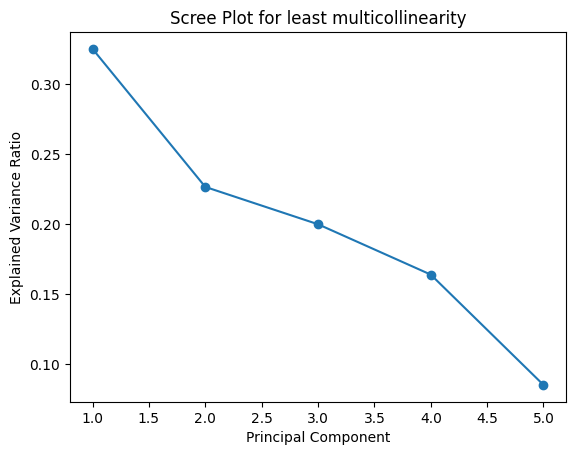

1 components: 0.3249
2 components: 0.5513
3 components: 0.7511
4 components: 0.9149
5 components: 1.0000


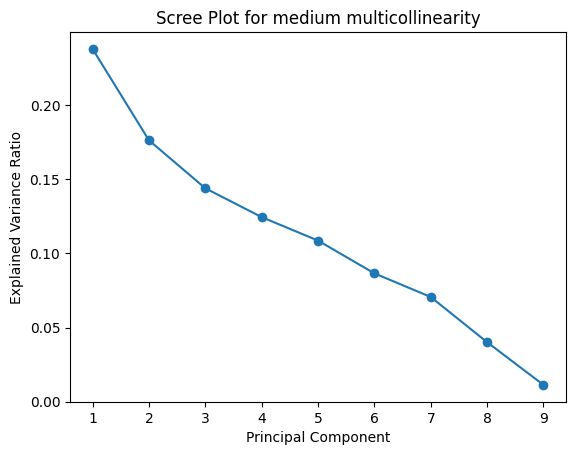

1 components: 0.2379
2 components: 0.4142
3 components: 0.5582
4 components: 0.6827
5 components: 0.7914
6 components: 0.8779
7 components: 0.9485
8 components: 0.9887
9 components: 1.0000


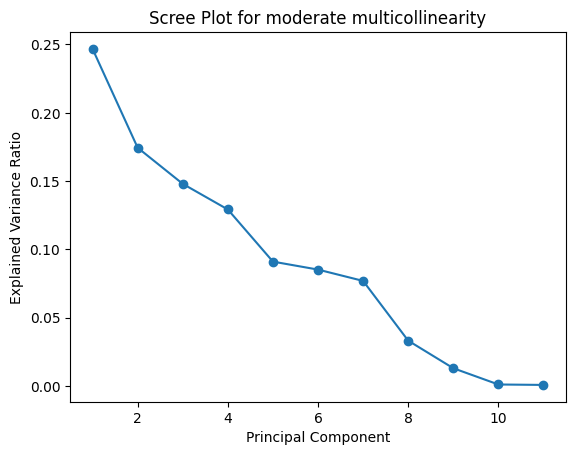

1 components: 0.2467
2 components: 0.4212
3 components: 0.5692
4 components: 0.6984
5 components: 0.7895
6 components: 0.8747
7 components: 0.9517
8 components: 0.9849
9 components: 0.9980
10 components: 0.9992
11 components: 1.0000


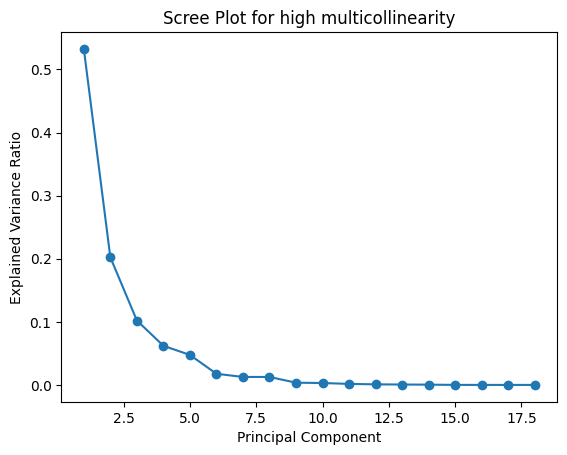

1 components: 0.5324
2 components: 0.7347
3 components: 0.8368
4 components: 0.8988
5 components: 0.9464
6 components: 0.9641
7 components: 0.9768
8 components: 0.9894
9 components: 0.9930
10 components: 0.9960
11 components: 0.9977
12 components: 0.9987
13 components: 0.9993
14 components: 0.9998
15 components: 0.9999
16 components: 0.9999
17 components: 1.0000
18 components: 1.0000


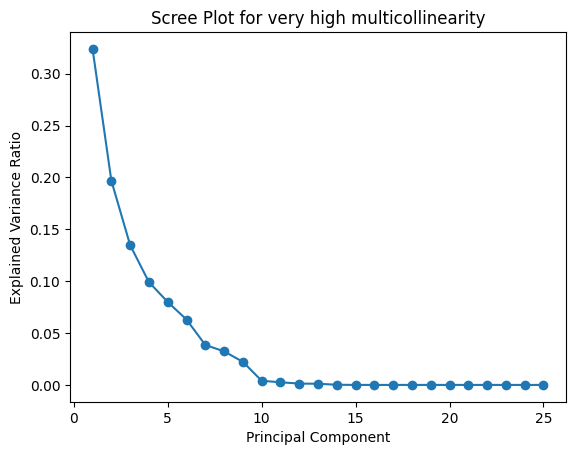

1 components: 0.3239
2 components: 0.5209
3 components: 0.6556
4 components: 0.7547
5 components: 0.8347
6 components: 0.8977
7 components: 0.9363
8 components: 0.9686
9 components: 0.9909
10 components: 0.9949
11 components: 0.9974
12 components: 0.9987
13 components: 0.9998
14 components: 1.0000
15 components: 1.0000
16 components: 1.0000
17 components: 1.0000
18 components: 1.0000
19 components: 1.0000
20 components: 1.0000
21 components: 1.0000
22 components: 1.0000
23 components: 1.0000
24 components: 1.0000
25 components: 1.0000


In [6]:
X = X.apply(zscore)

for group in group_labels:
    # Get the features in the current group
    group_features = vif[vif_groups == group]['Feature']
    X_group = X[group_features]

    if(len(group_features)==0):
        continue

    # Apply PCA to the features in the current group
    pca = PCA()
    pca.fit(X_group)
    
    # Generate a scree plot for the current group
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title(f'Scree Plot for {group}')
    plt.show()
    
    # Print the cumulative explained variance ratio
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    for i, variance_ratio in enumerate(cumsum):
        print(f"{i+1} components: {variance_ratio:.4f}")
    
    # Store the number of principal components for the current group in the dictionary
    n_components_dict[group] = int(input(f"Enter the number of principal components for {group}: "))

In [7]:
pca = PCA()
X_pca_list = []
for group in group_labels:
    # Get the features in the current group
    group_features = vif[vif_groups == group]['Feature']
    if(len(group_features)==0):
        continue
    X_group = X[group_features]

    # Apply PCA to the features in the current group with the chosen number of components
    pca.n_components = n_components_dict[group]
    X_pca = pca.fit_transform(X_group)
    X_pca = pd.DataFrame(X_pca, columns=[f'{group}_PCA{i+1}' for i in range(pca.n_components)])

    # Add the PCA features to a new DataFrame that includes the Label column
    X_pca_list.append(pd.concat([X_pca, y], axis=1))

In [8]:
# Concatenate the PCA DataFrames
X_pca = pd.concat(X_pca_list, axis=1)

X_pca1 = X_pca.T.drop_duplicates().T
for r in result:
    X_pca1 = pd.concat([X_pca1, X[r]], axis=1)
print(X_pca1.shape)
X_pca1.to_csv('CICIDS-new_dataset.csv', index=False)

(10000, 34)


Sampling
Random undersampling with replacement
Over sampling using SMOTE

In [9]:
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(r'CICIDS-new_dataset.csv')

# Replace infinite and NaN values with 0
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(value=0, inplace=True)

# Drop any rows with missing values
df.dropna(inplace=True)

# Drop columns with zero variance
df = df.loc[:, (df != df.iloc[0]).any()]

# Split the DataFrame into X (features) and y (labels)
X = df.drop("Label", axis=1)
y = df['Label']

In [10]:
# Define the undersampling method
rus = RandomUnderSampler(random_state=42, replacement=True)

# Define the oversampling method
smote = SMOTE(random_state=42)

# Perform random undersampling
X_under, y_under = rus.fit_resample(X, y)

# Perform SMOTE oversampling on the undersampled data
X_resampled, y_resampled = smote.fit_resample(X_under, y_under)

# Check the class distribution of the resampled data
print(pd.Series(y_resampled).value_counts())

# Now you can use X_resampled and y_resampled for your modeling purposes
result = pd.concat([X_resampled, y_resampled], axis=1)
result.to_csv('CICIDS-sampled_dataset.csv', index=False)

BENIGN      875
DDoS        875
DoS         875
PortScan    875
Name: Label, dtype: int64


In [11]:
df = pd.read_csv(r'CICIDS-sampled_dataset.csv')
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Applying Random forest model

In [12]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test

Accuracy of RF: 0.9971428571428571
Precision of RF: 0.9971497584541064
Recall of RF: 0.9971428571428571
F1-score of RF: 0.9971424155670201
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00       206
        DDoS       1.00      1.00      1.00       170
         DoS       0.99      0.99      0.99       159
    PortScan       1.00      0.99      1.00       165

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700



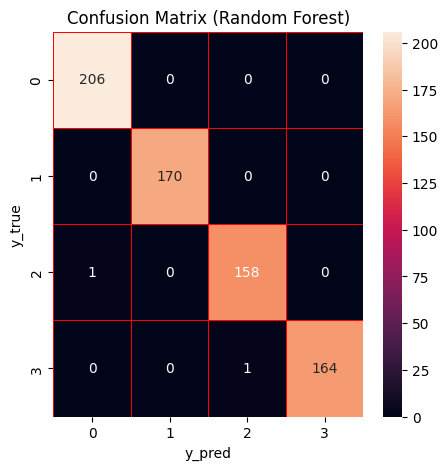

In [13]:
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.title("Confusion Matrix (Random Forest)")
plt.ylabel("y_true")
plt.show()

In [14]:
rf_train = rf.predict(X_train)
rf_test = rf.predict(X_test)

Applying K-Nearest Neighbours model

In [15]:
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train, y_train)

# Predict the labels of the test data
y_pred = knn.predict(X_test)
y_true = y_test

Accuracy of KNN: 0.9071428571428571
Precision of KNN: 0.9124423445809244
Recall of KNN: 0.9071428571428571
F1-score of KNN: 0.9055573089557475
              precision    recall  f1-score   support

      BENIGN       0.97      0.79      0.87       206
        DDoS       0.89      0.96      0.92       170
         DoS       0.91      0.91      0.91       159
    PortScan       0.87      0.99      0.93       165

    accuracy                           0.91       700
   macro avg       0.91      0.91      0.91       700
weighted avg       0.91      0.91      0.91       700



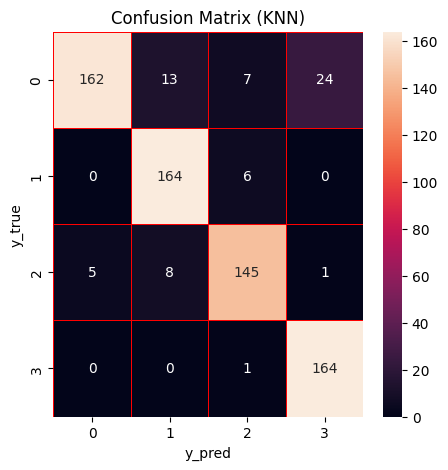

In [16]:
accuracy = accuracy_score(y_test, y_pred)
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_pred, average='weighted') 

print('Accuracy of KNN: '+(str(accuracy)))
print('Precision of KNN: '+(str(precision)))
print('Recall of KNN: '+(str(recall)))
print('F1-score of KNN: '+(str(fscore)))

print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)

# Generate the accuracy confusion matrix
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.title("Confusion Matrix (KNN)")
plt.ylabel("y_true")
plt.show()

In [17]:
knn_train = knn.predict(X_train)
knn_test = knn.predict(X_test)

Applying XG Boosting model

In [18]:
lb_make = LabelEncoder()
df["Label"] = lb_make.fit_transform(df["Label"])
df["Label"].value_counts()

0    875
1    875
2    875
3    875
Name: Label, dtype: int64

In [19]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
xgb_c = xgb.XGBClassifier(learning_rate=0.5,
    n_estimators=10,
    max_depth=3,
    subsample=0.1,
    colsample_bytree=0.8,
    random_state=42)
xgb_c.fit(X_train,y_train)
y_pred = xgb_c.predict(X_test)

Accuracy:  0.9871428571428571
Precision: 0.9871788166067342
Recall: 0.9871428571428571
F1-score: 0.9871483475585077 

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       206
           1       0.99      1.00      1.00       170
           2       0.97      0.97      0.97       159
           3       1.00      0.99      0.99       165

    accuracy                           0.99       700
   macro avg       0.99      0.99      0.99       700
weighted avg       0.99      0.99      0.99       700



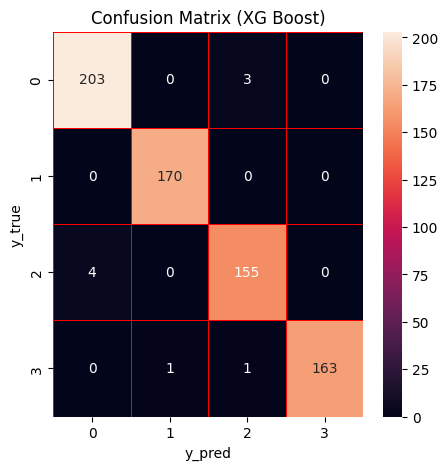

In [21]:
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred, average='weighted'),"\n")
print(classification_report(y_test,y_pred))

conf_mat = confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title("Confusion Matrix (XG Boost)")
plt.show()

In [22]:
xg_train = xgb_c.predict(X_train)
xg_test = xgb_c.predict(X_test)

Applying B-Stacking Algorithm

In [23]:
b_stack_model = pd.DataFrame( {
    'RandomForest': rf_train.ravel(),
    'KNN': knn_train.ravel(),
    'XgBoost': xg_train.ravel(),
    })
b_stack_model.head(5)

,RandomForest,KNN,XgBoost
0,BENIGN,PortScan,0
1,DDoS,DDoS,1
2,DDoS,DDoS,1
3,DDoS,DDoS,1
4,DDoS,DDoS,1


In [24]:
rf_train = lb_make.fit_transform(rf_train)
knn_train = lb_make.fit_transform(knn_train)
rf_test = lb_make.fit_transform(rf_test)
knn_test = lb_make.fit_transform(knn_test)

In [25]:
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
knn_train=knn_train.reshape(-1, 1)
knn_test=knn_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [26]:
x_train = np.concatenate(( rf_train, knn_train, xg_train), axis=1)
x_test = np.concatenate(( rf_test, knn_test, xg_test), axis=1)

In [27]:
stk = xgb.XGBClassifier(n_estimators=10, max_depth=1).fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test

Accuracy of Stacking: 0.9971428571428571
Precision of Stacking: 0.9971497584541064
Recall of Stacking: 0.9971428571428571
F1-score of Stacking: 0.9971424155670201
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       206
           1       1.00      1.00      1.00       170
           2       0.99      0.99      0.99       159
           3       1.00      0.99      1.00       165

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700



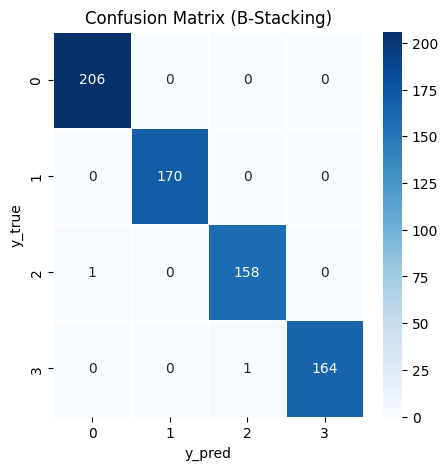

In [28]:
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,cmap="Blues",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title("Confusion Matrix (B-Stacking)")
plt.show()